In [68]:
%matplotlib inline
from time import time
import logging
import pylab as pl
import numpy as np
#import json

from matplotlib import pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC



# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [69]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes
#print target_names

2018-01-19 11:19:51,095 Loading LFW people faces from C:\Users\MLUSER\scikit_learn_data\lfw_home


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [70]:
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [71]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized').fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)

Extracting the top 150 eigenfaces from 966 faces
done in 0.493s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.064s


0.193465272798
0.151168455012


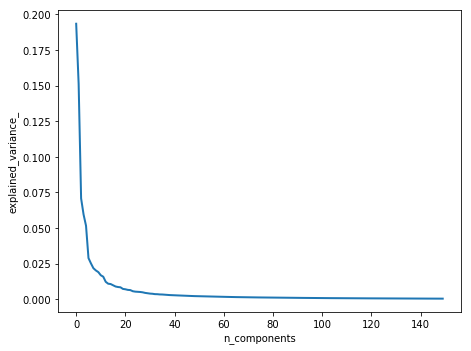

In [72]:
# Calculate and plot the variance (and its ratio) of each eigenface
pc_var = pca.explained_variance_ 
pc_var_ratio =pca.explained_variance_ratio_
print pc_var_ratio[0]
print pc_var_ratio[1]


plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [73]:
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 18.381s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [74]:
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))

Predicting the people names on the testing set
done in 0.048s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.74      0.87      0.80        60
  Donald Rumsfeld       0.76      0.81      0.79        27
    George W Bush       0.93      0.87      0.90       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.88      0.83      0.86        36

      avg / total       0.84      0.83      0.83       322

[[  9   0   3   1   0   0   0]
 [  2  52   1   4   0   1   0]
 [  4   0  22   1   0   0   0]
 [  1  11   2 127   3   1   1]
 [  0   2   0   1  19   1   2]
 [  0   3   0   1   2   8   1]
 [  0   2   1   2   1   0  30]]


In [75]:
'''
# Pipelining PCA w/ different number of n_components and SVC with GridSearch
n_components_list = [10, 15, 25, 50, 100, 250]
Cs = [1e3, 5e3, 1e4, 5e4, 1e5]
gammas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
best_est_dict = {}

print "Fitting the classifier to the training set w/ different PCA component numbers"
for n in n_components_list:
    key = 'pca_' + str(n) + '_components'
    pca_n = PCA(n_components=n, whiten=True, svd_solver='randomized')
    pca_n.fit(X_train)
    svc_n = SVC(kernel='rbf', class_weight='balanced')
    pipe = Pipeline(steps=[('pca', pca_n), ('svc', svc_n)])
    
    estimator = GridSearchCV(pipe, dict(svc__C=Cs, svc__gamma=gammas))
    X_train_pca = pca_n.transform(X_train)
    estimator = estimator.fit(X_train_pca, y_train)
    best_est_dict[key] = estimator.best_estimator_
    print 'The best SVC classifier using ' + str(n) + ' principal components is found!' 
    
for n, clf in best_est_dict.items():
    print 'Best estimator found by grid search with ' + n + ':'
    print clf
    print ''
'''

'\n# Pipelining PCA w/ different number of n_components and SVC with GridSearch\nn_components_list = [10, 15, 25, 50, 100, 250]\nCs = [1e3, 5e3, 1e4, 5e4, 1e5]\ngammas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]\nbest_est_dict = {}\n\nprint "Fitting the classifier to the training set w/ different PCA component numbers"\nfor n in n_components_list:\n    key = \'pca_\' + str(n) + \'_components\'\n    pca_n = PCA(n_components=n, whiten=True, svd_solver=\'randomized\')\n    pca_n.fit(X_train)\n    svc_n = SVC(kernel=\'rbf\', class_weight=\'balanced\')\n    pipe = Pipeline(steps=[(\'pca\', pca_n), (\'svc\', svc_n)])\n    \n    estimator = GridSearchCV(pipe, dict(svc__C=Cs, svc__gamma=gammas))\n    X_train_pca = pca_n.transform(X_train)\n    estimator = estimator.fit(X_train_pca, y_train)\n    best_est_dict[key] = estimator.best_estimator_\n    print \'The best SVC classifier using \' + str(n) + \' principal components is found!\' \n    \nfor n, clf in best_est_dict.items():\n    print \'Bes

In [76]:
'''
# Quantitative evaluation of the model quality on the test set with different principal components#
target_name = target_names[0]
print [target_name]

for n, clf in best_est_dict.items():
    pca_n = clf.named_steps['pca']
    X_test_pca = pca_n.fit(X_train).transform(X_test)
  
    svc_n = clf.named_steps['svc']
    y_pred = svc_n.predict(X_test_pca)

    #import pdb; pdb.set_trace()
    
    print 'SVC classifier with ' + n 
    print classification_report(y_test, y_pred, target_names=target_names)
    print ''
'''

"\n# Quantitative evaluation of the model quality on the test set with different principal components#\ntarget_name = target_names[0]\nprint [target_name]\n\nfor n, clf in best_est_dict.items():\n    pca_n = clf.named_steps['pca']\n    X_test_pca = pca_n.fit(X_train).transform(X_test)\n  \n    svc_n = clf.named_steps['svc']\n    y_pred = svc_n.predict(X_test_pca)\n\n    #import pdb; pdb.set_trace()\n    \n    print 'SVC classifier with ' + n \n    print classification_report(y_test, y_pred, target_names=target_names)\n    print ''\n"

In [77]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

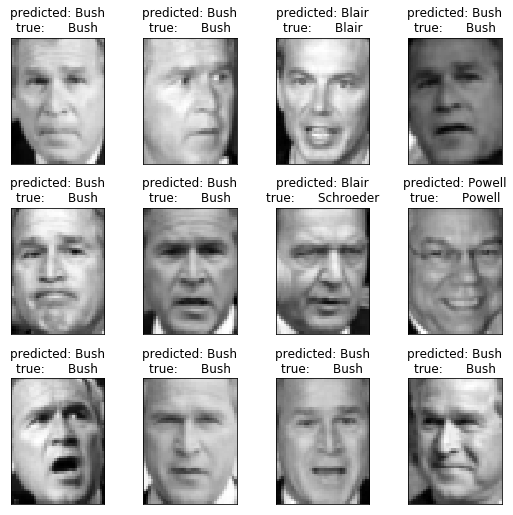

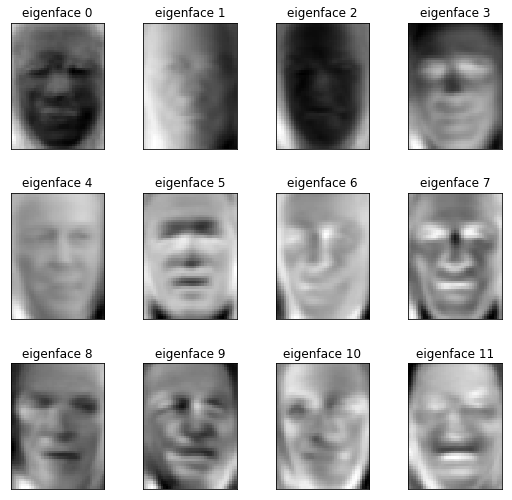

In [78]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()